In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/MyDrive/data/training_data
from pathlib import Path
train_root = Path('/content/gdrive/MyDrive/data/training_data')
test_root = Path('/content/gdrive/MyDrive/data/test')
!ls /content/gdrive/MyDrive/data/training_data/smoking | wc -l


Mounted at /content/gdrive


In [ ]:

import tensorflow as tf
# Build input pipeline with Keras
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    subset = "training",
    validation_split = 0.2,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    subset = "validation",
    validation_split = 0.2,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 2010 files belonging to 2 classes.
Using 1608 files for training.
Found 2010 files belonging to 2 classes.
Using 402 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['notsmoking', 'smoking']


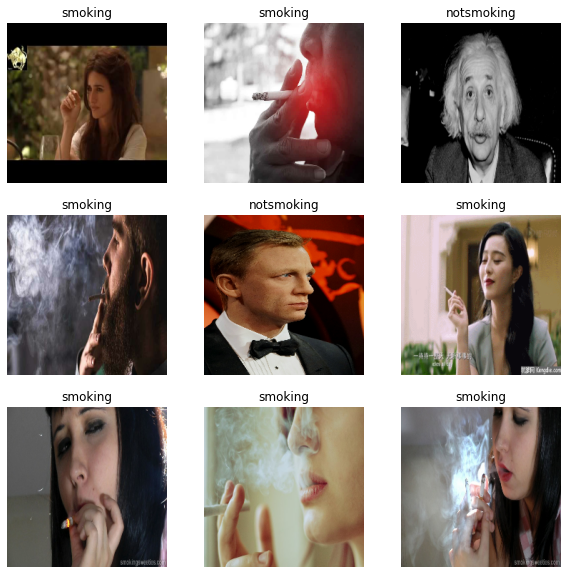

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("ofF")

In [ ]:
filelist_ds = tf.data.Dataset.list_files(str(train_root/'*/*'))
for file in filelist_ds.take(9):
  print(file)
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  if parts[-2] == "smoking":
    labels = [1,0]
  else:
    labels = [0,1]
  return tf.convert_to_tensor(labels)

for file in filelist_ds.take(9):
  print('filename: ', file.numpy().decode('utf-8'))
  print('label: ',get_label(file).numpy())

tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0039.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0217.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0207.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0173.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0218.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0833.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/smoking/smoking_0778.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/smoking/smoking_0826.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_1071.jpg', shape=(), dtype=string)
file

In [ ]:
img_height = 224
img_width = 224
def preprocessing(file_path):
  #read file
  img = tf.io.read_file(file_path)
  img = tf.image.decode_image(img, channels = 3, expand_animations = False) 

  #tranform
  #convert from uint8 to float and normalize value to [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)
  #resize image
  img = tf.image.resize(img ,[img_width, img_height])
  #get image label
  label = get_label(file_path)

  #return
  return img, label

In [ ]:
import tensorflow as tf

batch_size =32
train_ds = filelist_ds.shuffle(1608) 
train_ds = train_ds.map(preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(1)
val_ds = filelist_ds.shuffle(402) 
val_ds = val_ds.map(preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(1)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

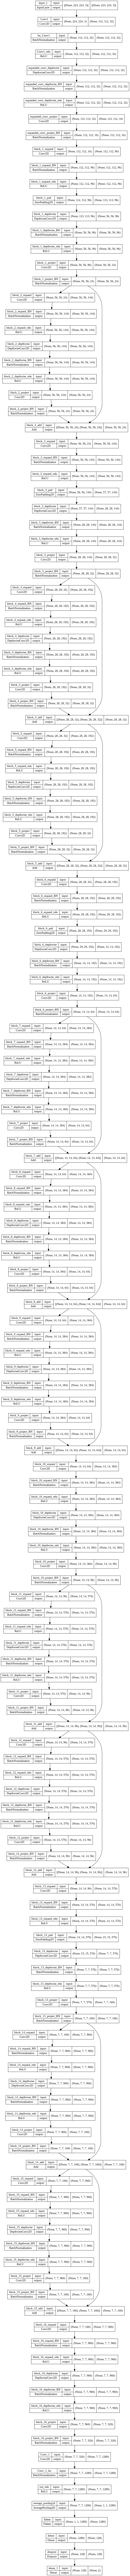

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops.gen_dataset_ops import optimize_dataset
# compile model
for layer in baseModel.layers:
    layer.trainable = False
opt = Adam(lr=1e-4, decay=1e-4 / 30)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
H = model.fit(train_ds,
              validation_data = val_ds,
              epochs = 20)

Epoch 1/20
63/63 [==============================] - 83s 899ms/step - loss: 0.7193 - accuracy: 0.6189 - val_loss: 0.5368 - val_accuracy: 0.7995
Epoch 2/20
63/63 [==============================] - 59s 946ms/step - loss: 0.5415 - accuracy: 0.7577 - val_loss: 0.4431 - val_accuracy: 0.8423
Epoch 3/20
63/63 [==============================] - 60s 965ms/step - loss: 0.4624 - accuracy: 0.8090 - val_loss: 0.3889 - val_accuracy: 0.8597
Epoch 4/20
63/63 [==============================] - 57s 915ms/step - loss: 0.4237 - accuracy: 0.8274 - val_loss: 0.3563 - val_accuracy: 0.8627
Epoch 5/20
63/63 [==============================] - 59s 943ms/step - loss: 0.3756 - accuracy: 0.8517 - val_loss: 0.3333 - val_accuracy: 0.8657
Epoch 6/20
63/63 [==============================] - 59s 946ms/step - loss: 0.3603 - accuracy: 0.8507 - val_loss: 0.3110 - val_accuracy: 0.8806
Epoch 7/20
63/63 [==============================] - 60s 960ms/step - loss: 0.3385 - accuracy: 0.8687 - val_loss: 0.2934 - val_accuracy: 0.8925

In [ ]:
model_store_dir='/content/gdrive/MyDrive/weight.h5'
model_json = model.to_json()
with open("model_arch.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_store_dir, save_format="h5")

In [ ]:
model.load_weights("/content/gdrive/MyDrive/weight.h5")
print(model)

<function matplotlib.pyplot.show>

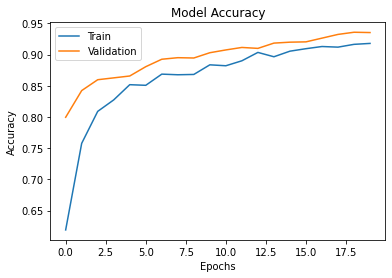

In [ ]:
# Vẽ đồ thị giữa số lần học (Epochs) và độ chính xác (Accuracy)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])
plt.show

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=1e-4, decay=1e-4 / 30)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from pathlib import Path
train_root = Path('/content/gdrive/MyDrive/data/training_data')
test_root = Path('/content/gdrive/MyDrive/data/test')

In [ ]:
filelist_ds = tf.data.Dataset.list_files(str(train_root/'*/*'))
for file in filelist_ds.take(9):
  print(file)

tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/smoking/smoking_0702.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_1036.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0126.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/smoking/smoking_0431.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0096.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0287.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/smoking/smoking_0053.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/smoking/smoking_0795.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/data/training_data/notsmoking/notsmoking_0366.jpg', shape=(), dtype=string)


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/model_arch.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/gdrive/MyDrive/data/weight.h5")
print(model)
img_path = '/content/ls.jpg'
image = tf.keras.utils.load_img(
    img_path,
    grayscale=False,
    color_mode='rgb',
    target_size=(224, 224),
    interpolation='nearest',
)

In [ ]:
import numpy as np
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)


In [ ]:
print(predictions[0][0])

0.44089764


[[0.44089764 0.55910236]]
Not Smoking


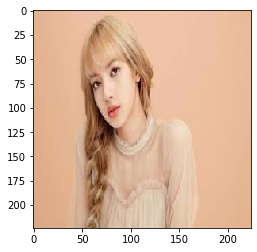

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
print(predictions)
if (predictions[0][0] > 0.5):
  print('Smoking')
else: 
  print('Not Smoking')